# Cluster Comparisons

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.cluster import SpectralClustering, AffinityPropagation, OPTICS, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan
import seaborn as sns
from random import randint
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances

In [5]:
# Load your basketball dataset into a pandas DataFrame
df = pd.read_csv('seasonStats2.csv')

df = df.loc[(df['Season'] >= 2003) & (df['Season'] <= 2023) & (df["HighDay"] >= -1) & (df["TeamID"] > 0)]
#df = df.loc[(df['Season'] == 2004) & (df["HighDay"] >= -1) & (df["TeamID"] > 0)] 
df = df[df["AVGFGA"] != -1]

statsToMeasure = ["Score", "FGM", "FGA", "FGM3", "FGA3", "FTM", "FTA", "OR", "DR", "Ast", "TO", "Stl", "Blk", "PF"]
statsMeasured = ["RAT" + stat for stat in statsToMeasure]

selected = statsMeasured
x = df.loc[:, statsMeasured].values
y = df.loc[:,['HighDay']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ["pc1", "pc2", "pc3", "pc4", "pc5", "pc6"])


df.reset_index(inplace=True)

principalDf["HighDay"] = df["HighDay"]
principalDf["GamesWon"] = df["GamesWon"]
principalDf["TeamID"] = df["TeamID"]

principalDf.loc[(principalDf["GamesWon"] >= 0) & (principalDf["GamesWon"] <=4), "GamesWon"] = 4
principalDf.loc[(principalDf["GamesWon"] >= 5) & (principalDf["GamesWon"] <=8), "GamesWon"] = 8
principalDf.loc[(principalDf["GamesWon"] >= 9) & (principalDf["GamesWon"] <= 12), "GamesWon"] = 12
principalDf.loc[(principalDf["GamesWon"] >= 13) & (principalDf["GamesWon"] <=16), "GamesWon"] = 16
principalDf.loc[(principalDf["GamesWon"] >= 17) & (principalDf["GamesWon"] <=20), "GamesWon"] = 20
principalDf.loc[(principalDf["GamesWon"] >= 21) & (principalDf["GamesWon"] <= 24), "GamesWon"] = 24
principalDf.loc[(principalDf["GamesWon"] >= 25) & (principalDf["GamesWon"] <=28), "GamesWon"] = 28
principalDf.loc[(principalDf["GamesWon"] >= 29) & (principalDf["GamesWon"] <=32), "GamesWon"] = 32
principalDf.loc[(principalDf["GamesWon"] >= 33) & (principalDf["GamesWon"] <= 36), "GamesWon"] = 36
principalDf.loc[(principalDf["GamesWon"] >= 37), "GamesWon"] = 40


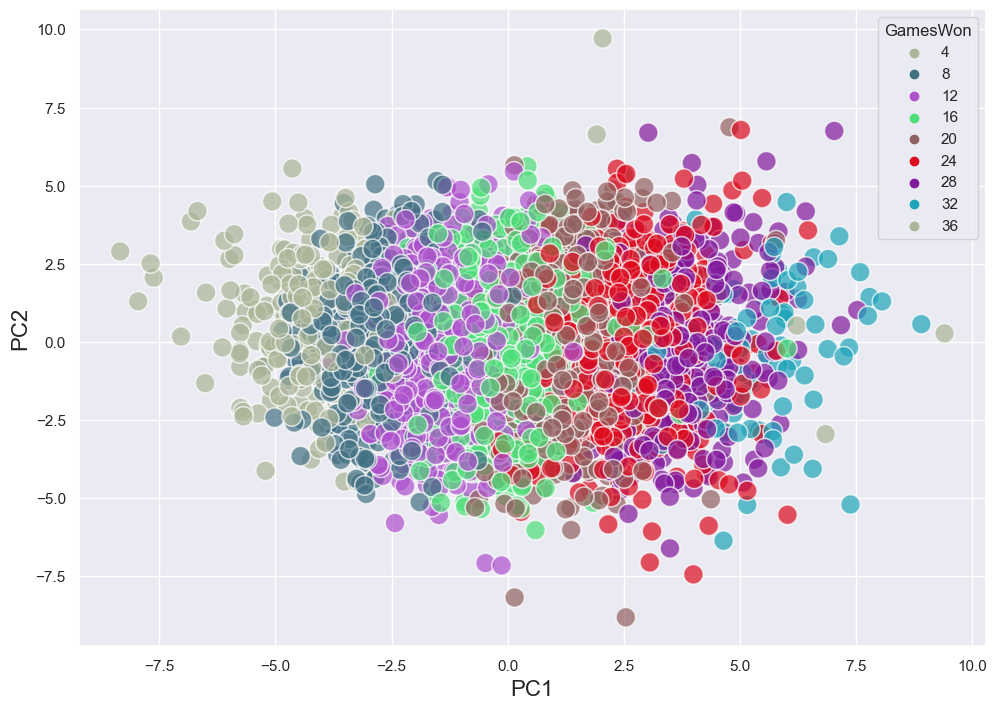

In [6]:
import random
colors = []
n = 8
random.seed(35)
for i in range(n):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.scatterplot(data=principalDf, x="pc1", y = "pc2", hue="GamesWon", palette=colors, s=200, alpha=0.7)

ax.set_xlabel("PC1", size=16)
ax.set_ylabel("PC2", size=16)

#plt.savefig("./plots/pca.png",dpi=200)

plt.show()

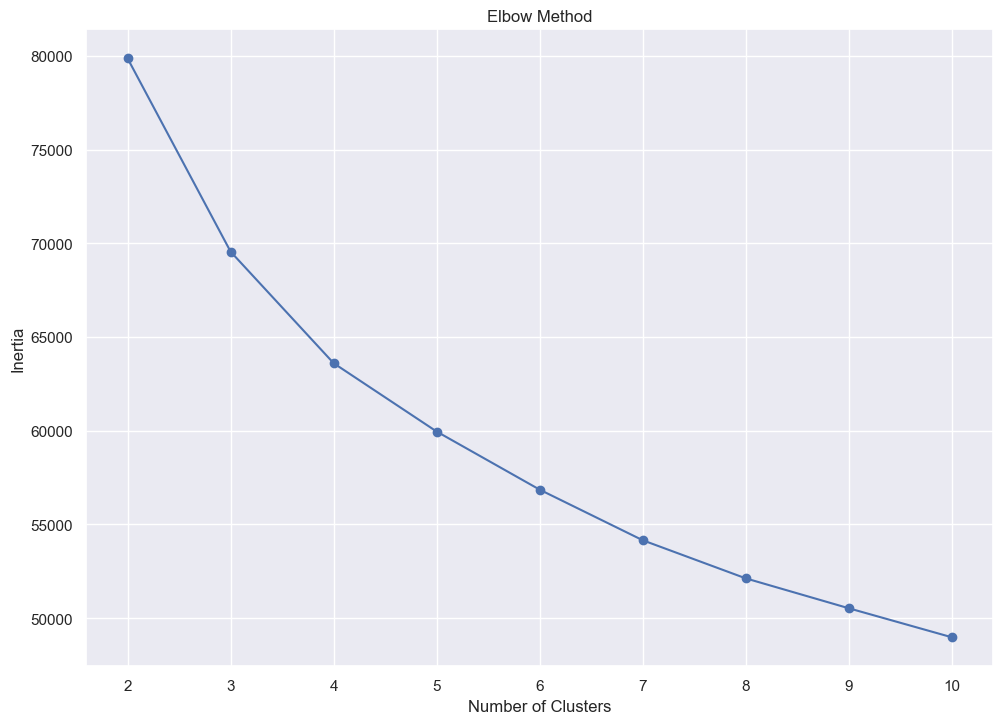

In [7]:
# Define the range of clusters to test
min_clusters = 2
max_clusters = 10

#  Elbow Method
inertia = []
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(min_clusters, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

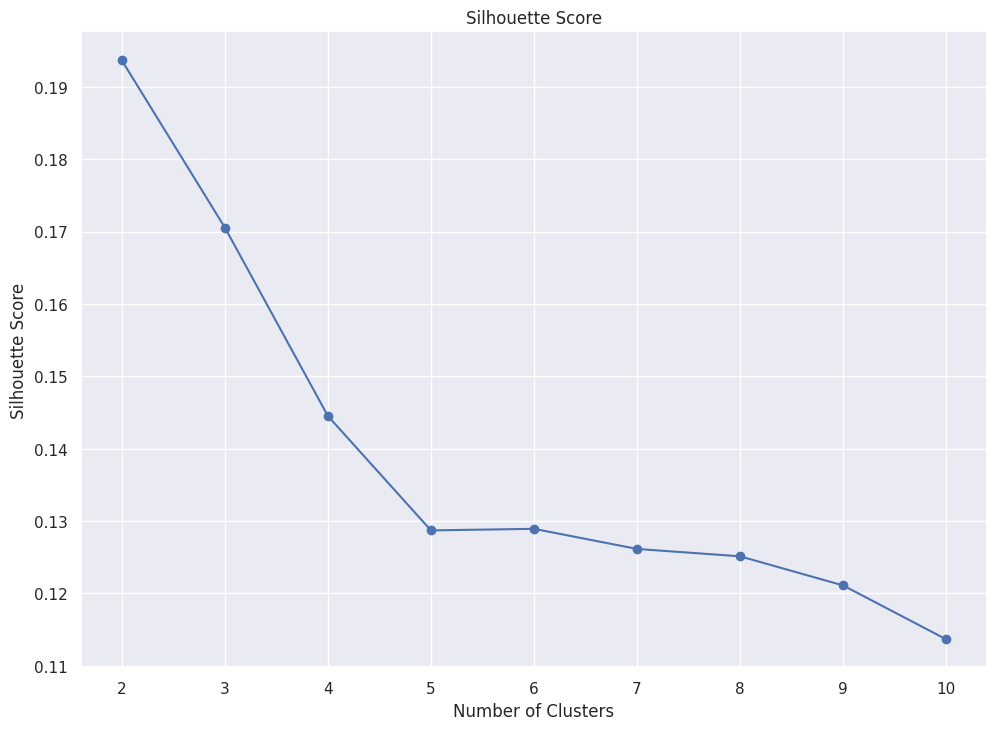

In [19]:
# Silhouette Score
silhouette_scores = []
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x)
    score = silhouette_score(x, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

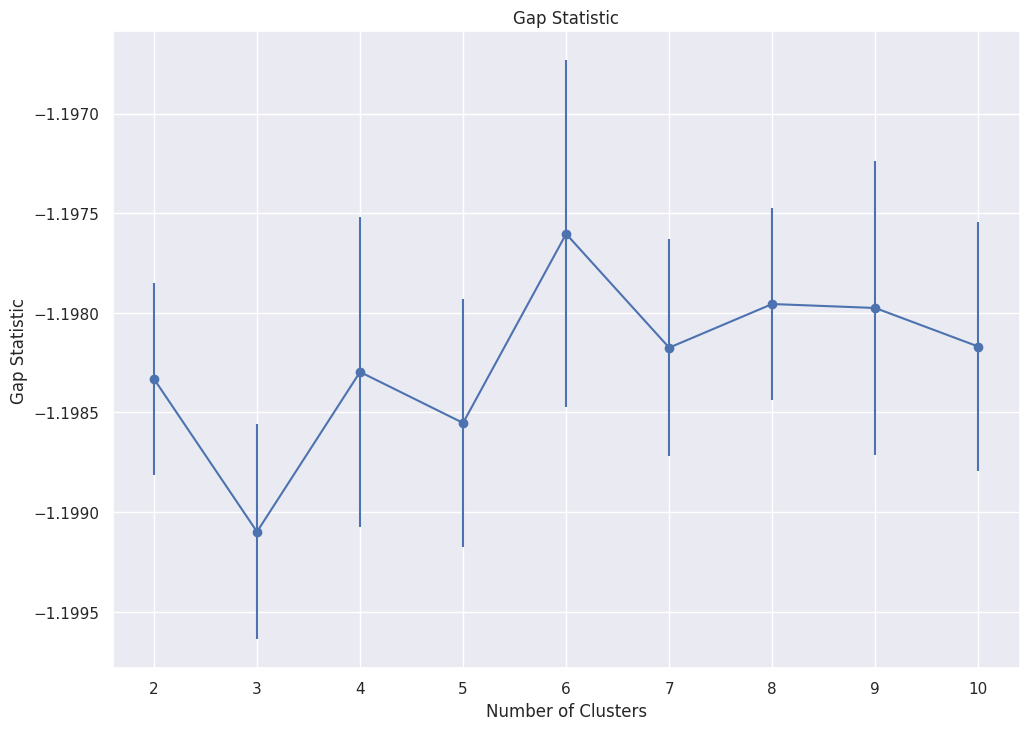

In [25]:
# Gap Statistic
def compute_gap_statistic(data, clustering_func, n_refs=10, max_clusters=10):
    reference_dispersion = np.zeros(max_clusters - 1)
    reference_dispersion_std = np.zeros(max_clusters - 1)
    dispersion = np.zeros(max_clusters - 1)

    for n_clusters in range(2, max_clusters + 1):
        reference_dispersion_scores = np.zeros(n_refs)
        for i in range(n_refs):
            reference_data = np.random.random_sample(size=data.shape)
            clustering_model = clustering_func(n_clusters=n_clusters)
            reference_labels = clustering_model.fit_predict(reference_data)
            reference_dispersion_scores[i] = np.mean(pairwise_distances(reference_data[reference_labels >= 0, :]))

        reference_dispersion[n_clusters - 2] = np.mean(reference_dispersion_scores)
        reference_dispersion_std[n_clusters - 2] = np.std(reference_dispersion_scores)
        clustering_model = clustering_func(n_clusters=n_clusters)
        labels = clustering_model.fit_predict(data)
        dispersion[n_clusters - 2] = np.mean(pairwise_distances(data[labels >= 0, :]))

    gap_scores = np.log(reference_dispersion) - np.log(dispersion)
    gap_scores_err = np.sqrt(1 + 1 / n_refs) * reference_dispersion_std / np.abs(dispersion - reference_dispersion)

    return gap_scores, gap_scores_err

gap_scores, gap_scores_err = compute_gap_statistic(x, KMeans, n_refs=10, max_clusters=10)

# Plot the gap statistic
plt.errorbar(range(2, max_clusters + 1), gap_scores, yerr=gap_scores_err, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic')
plt.show()


In [56]:
num_clusters = 5
data = principalDf.loc[:, ['pc1', 'pc2']]
# Clustering algorithms
clustering_algorithms = [
    ("K-means", KMeans(n_clusters=num_clusters, random_state=42)),
    ("Agglomerative Clustering", AgglomerativeClustering(n_clusters=num_clusters)),
    ("BIRCH", Birch(n_clusters=num_clusters)),
    ("Gaussian Mixture Models", GaussianMixture(n_components=num_clusters)),
    ("Mini Batch K-Means", MiniBatchKMeans(n_clusters=num_clusters, random_state=42)),
    ("Spectral Clustering", SpectralClustering(n_clusters=num_clusters)),
    ("Affinity Propagation", AffinityPropagation(convergence_iter=5)),
    ("OPTICS", OPTICS(min_samples=5)),
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=5)),
    ("HDBSCAN", hdbscan.HDBSCAN(min_cluster_size=5))
]   



In [58]:

# Perform clustering and evaluate
evaluation_metrics = []
for name, algorithm in clustering_algorithms:
    if name == "Gaussian Mixture Models":
        algorithm.fit(data)
        labels = algorithm.predict(data)
    else:
        algorithm.fit(data)
        labels = algorithm.labels_
    silhouette = silhouette_score(data, labels)
    db_score = davies_bouldin_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)
    evaluation_metrics.append((name, silhouette, db_score, ch_score))


In [59]:

# Print the evaluation metrics
print("Evaluation Metrics:")
print("Good value: Silhouette Score=Higher, DB=Lower , CH=Higher")
for name, silhouette, db_score, ch_score in evaluation_metrics:
    print(f"{name}: Silhouette Score={silhouette:.3f}, DB Score={db_score:.3f}, CH Score={ch_score:.3f}")



Evaluation Metrics:
Good value: Silhouette Score=Higher, DB=Lower , CH=Higher
K-means: Silhouette Score=0.317, DB Score=0.919, CH Score=4218.271
Agglomerative Clustering: Silhouette Score=0.249, DB Score=1.095, CH Score=3266.378
BIRCH: Silhouette Score=0.223, DB Score=1.011, CH Score=2643.706
Gaussian Mixture Models: Silhouette Score=0.315, DB Score=0.916, CH Score=3994.652
Mini Batch K-Means: Silhouette Score=0.293, DB Score=0.970, CH Score=3926.945
Spectral Clustering: Silhouette Score=0.300, DB Score=1.107, CH Score=421.683
Affinity Propagation: Silhouette Score=0.125, DB Score=0.344, CH Score=167.065
OPTICS: Silhouette Score=-0.140, DB Score=2.307, CH Score=11.926
DBSCAN: Silhouette Score=0.527, DB Score=3.866, CH Score=61.319
HDBSCAN: Silhouette Score=-0.238, DB Score=2.039, CH Score=14.691


In [56]:

# Print the evaluation metrics
print("Evaluation Metrics:")
print("Good value: Silhouette Score=Higher, DB=Lower , CH=Higher")
for name, silhouette, db_score, ch_score in evaluation_metrics:
    print(f"{name}: Silhouette Score={silhouette:.3f}, DB Score={db_score:.3f}, CH Score={ch_score:.3f}")



Evaluation Metrics:
Good value: Silhouette Score=Higher, DB=Lower , CH=Higher
K-means: Silhouette Score=0.332, DB Score=0.979, CH Score=4269.746
DBSCAN: Silhouette Score=0.286, DB Score=3.253, CH Score=18.493
Agglomerative Clustering: Silhouette Score=0.276, DB Score=1.083, CH Score=3401.710
Mini Batch K-Means: Silhouette Score=0.329, DB Score=0.982, CH Score=4147.124
HDBSCAN: Silhouette Score=-0.117, DB Score=4.289, CH Score=42.284
Spectral Clustering: Silhouette Score=0.326, DB Score=0.970, CH Score=3748.385
Affinity Propagation: Silhouette Score=0.105, DB Score=0.334, CH Score=153.221
OPTICS: Silhouette Score=-0.455, DB Score=1.998, CH Score=12.922
BIRCH: Silhouette Score=0.258, DB Score=1.062, CH Score=2457.307
Gaussian Mixture Models: Silhouette Score=0.331, DB Score=0.966, CH Score=3905.589


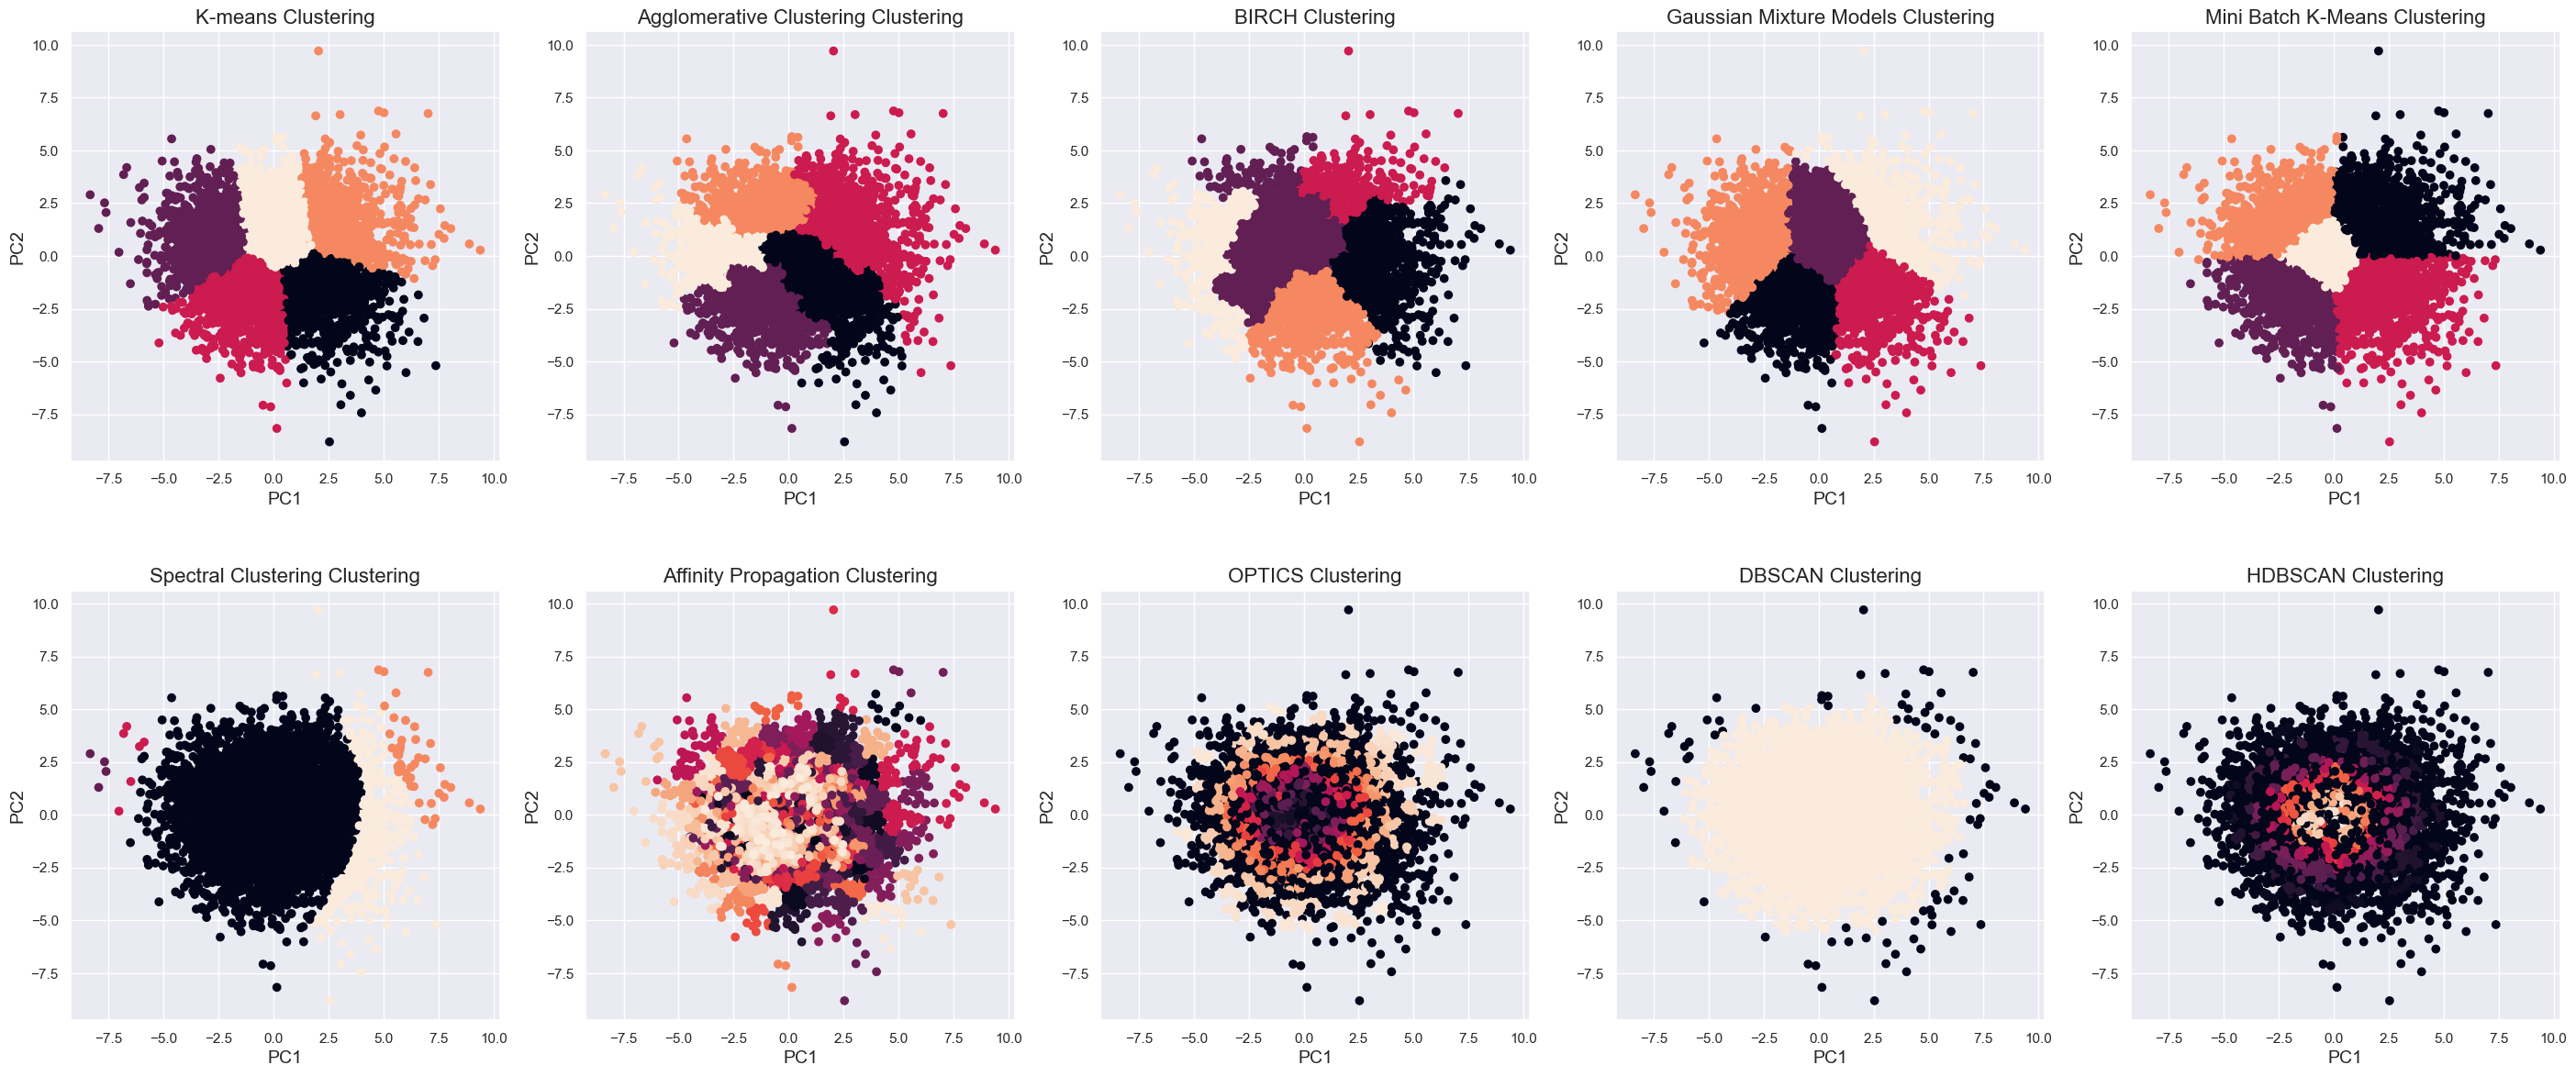

In [63]:
# Visualize the clusters using PCA
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(35, 14))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3)

for i, (name, algorithm) in enumerate(clustering_algorithms, 1):
    row = (i - 1) // num_cols
    col = (i - 1) % num_cols
    ax = axes[row, col]

    if name == "Gaussian Mixture Models":
        algorithm.fit(data)
        labels = algorithm.predict(principalDf.loc[:, ['pc1', 'pc2']])
    else:
        algorithm.fit(principalDf.loc[:, ['pc1', 'pc2']])
        labels = algorithm.labels_
    
    ax.scatter(principalDf['pc1'], principalDf['pc2'], c=labels)
    ax.set_title(f"{name} Clustering", fontsize=16)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)


# Save all plots to a single file
plt.savefig("clustering_pc2.png", dpi=200)
plt.show()


In [6]:
num_clusters = 3
data = principalDf.loc[:, ['pc1', 'pc2']]
# Clustering algorithms
# Removed Affinity Propagation, OPTICS, DBSCAN, HDBSCAN
revised_clustering_algorithms = [
    ("K-means", KMeans(n_clusters=num_clusters, random_state=42)),
    ("Agglomerative Clustering", AgglomerativeClustering(n_clusters=num_clusters)),
    ("Mini Batch K-Means", MiniBatchKMeans(n_clusters=num_clusters, random_state=42)),
    ("Spectral Clustering", SpectralClustering(n_clusters=num_clusters)),
    ("BIRCH", Birch(n_clusters=num_clusters)),
    ("Gaussian Mixture Models", GaussianMixture(n_components=num_clusters))
]


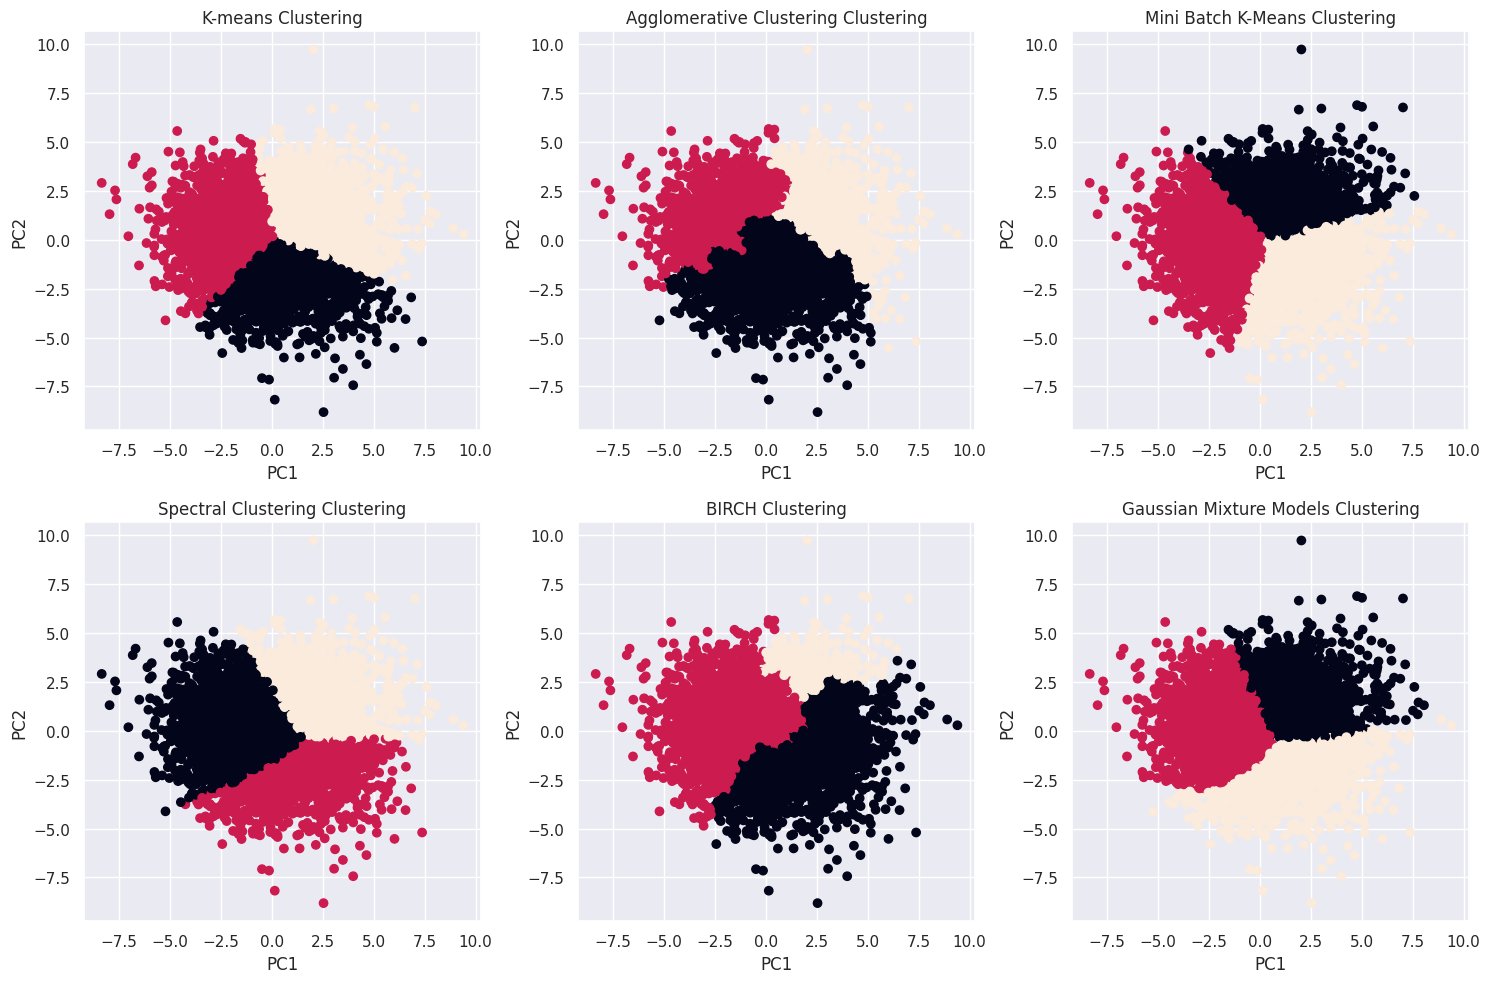

In [7]:
# Visualize the clusters using PCA
num_rows = len(revised_clustering_algorithms) // 3 + (len(revised_clustering_algorithms) % 3 > 0)
num_cols = min(len(revised_clustering_algorithms), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, (name, algorithm) in enumerate(revised_clustering_algorithms, 1):
    row = (i - 1) // num_cols
    col = (i - 1) % num_cols
    ax = axes[row, col]

    if name == "Gaussian Mixture Models":
        algorithm.fit(data)
        labels = algorithm.predict(principalDf.loc[:, ['pc1', 'pc2']])
    else:
        algorithm.fit(principalDf.loc[:, ['pc1', 'pc2']])
        labels = algorithm.labels_
    
    ax.scatter(principalDf['pc1'], principalDf['pc2'], c=labels)
    ax.set_title(f"{name} Clustering")
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# Remove empty subplots
if len(revised_clustering_algorithms) < num_rows * num_cols:
    for i in range(len(revised_clustering_algorithms), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()

# Save all plots to a single file
plt.savefig("clustering_pc2.png", dpi=200)
plt.show()


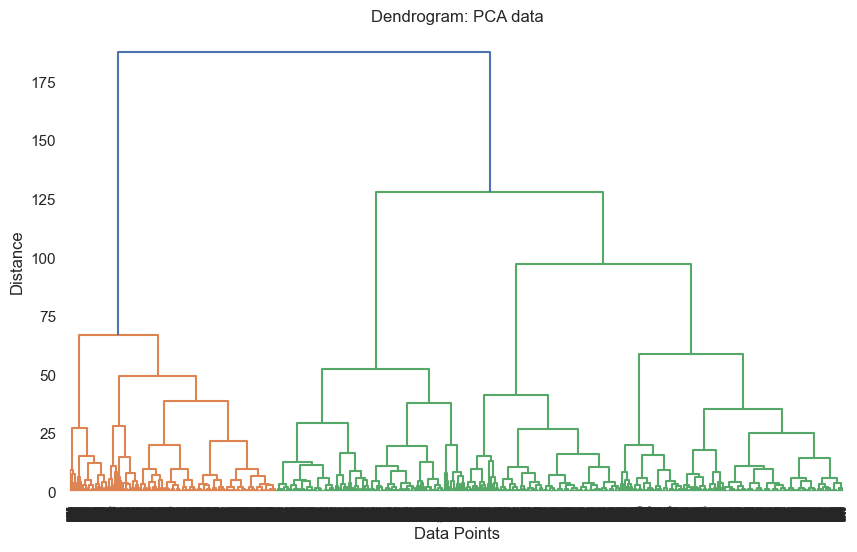

In [64]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering to obtain the linkage matrix
linkage_matrix = linkage(principalDf.loc[:, ['pc1', 'pc3']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram: PCA data')
plt.show()


